# Reduction to stationarity

## Preparations

In [ ]:
# Handling data
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# Autocorr test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Autocorrelation analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pmdarima

# auto ARIMA
import pmdarima as pm
from pmdarima import auto_arima

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Data

We'll be analyzing closing stocks prices. Get data from [here](https://www.nasdaq.com/market-activity/stocks/msft/historical?page=1&rows_per_page=10&timeline=y5).

Let's consider Microsoft  - 5 years of data. So, we have 1258 observations from 2019-11-18 up to 2024-11-15.

In [ ]:
stocks = pd.read_csv('microsoft.csv', parse_dates=['Date'])

In [ ]:
stocks.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-11-15,$415.00,28247640,$419.82,$422.80,$413.64
1,2024-11-14,$426.89,30246880,$425.00,$428.17,$420.00
2,2024-11-13,$425.20,21502190,$421.64,$429.325,$418.21
3,2024-11-12,$423.03,19401200,$418.25,$424.44,$417.20
4,2024-11-11,$418.01,24503320,$422.515,$424.81,$416.00


Here's some simple preprocessing.

In [ ]:
stocks.rename(columns={'Date':'ds', 'Close/Last':'y'}, inplace=True)
stocks['y'] = stocks['y'].apply(lambda x: x[1:]).astype(float)

stocks = stocks[['ds','y']].sort_values(by='ds').set_index('ds')

In [ ]:
stocks.head()

,y
ds,
2019-11-18,150.34
2019-11-19,150.39
2019-11-20,149.62
2019-11-21,149.48
2019-11-22,149.59


Let's plot our data.

In [ ]:
fig = px.line(stocks, x=stocks.index, y=stocks['y'],
              title="Microsoft closing prices (daily)")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

During lessons 3-4 we've discussed **ARMA** models, which work only with **stationary** time series.

Understanding and applying reduction to stationarity techniques is critical in time series analysis for several reasons. These techniques help transform data into a format that meets the assumptions of many statistical and machine learning models, allowing for more accurate and interpretable results.

During lessons 3-4 we discussed reduction to stationarity with differencing. Let's revise it and then move further to other tecniques.

## Differencing


Differencing is a common technique used to make a time series stationary by removing trends or seasonality. It is especially useful when the data shows patterns that change over time, such as increasing or decreasing trends. Differencing works by subtracting the current value from the previous value (or from values at regular intervals in the case of seasonal differencing), thereby stabilizing the mean and removing trends.

The order of differencing refers to how many times differencing is applied to the series. Usually, first order differencing may be sufficient.

**Formula** (1st order)

$ΔY_t = Y_t - Y_{t-1}$ or $y'_t = y_t - y_{t-1}$

In [ ]:
stocks['diff'] = stocks['y'].diff()
stocks.head()

,y,diff
ds,,
2019-11-18,150.34,NaN
2019-11-19,150.39,0.05
2019-11-20,149.62,-0.77
2019-11-21,149.48,-0.14
2019-11-22,149.59,0.11


Let's see if differencing of the 1st order made the time series stationary.

In [ ]:
fig = px.line(stocks, x=stocks.index, y=stocks['diff'],
              title="Microsoft closing prices (daily) - diff(1))")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Differenced time series looks stationary. However, it's always important to check for stationarity with a test. Here, ADF test will be sufficient, because we clearly see that the differenced time series must be stationary.

In [ ]:
adf_test(stocks['diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.160354e+01
p-value                        2.613911e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


<font color='green'>**p-value <= significance level (default: 0.05)**</font> => we reject H(0) and our ts is stationary (ADF).

But how do we reverse? One of the ways is with cumsum.

In [ ]:
y_0 = stocks['y'].iloc[0] # take the first value as the start
stocks['y_restored_diff'] = np.cumsum(stocks['diff'])+y_0
stocks

,y,diff,y_restored_diff
ds,,,
2019-11-18,150.34,NaN,NaN
2019-11-19,150.39,0.05,150.39
2019-11-20,149.62,-0.77,149.62
2019-11-21,149.48,-0.14,149.48
2019-11-22,149.59,0.11,149.59
...,...,...,...
2024-11-11,418.01,-4.53,418.01
2024-11-12,423.03,5.02,423.03
2024-11-13,425.20,2.17,425.20


Here we can plot the restored values and see, that they're the same as before.

In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=stocks.index, y=stocks['y'], mode='lines', name='original y', line=dict(color='silver'))
fig.add_scatter(x=stocks.index, y=stocks['y_restored_diff'], mode='lines', name='restored y', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Occasionally the differenced data will not appear to be stationary and it may be necessary to difference the data a 2nd time to obtain a stationary series.In practice, it is almost never necessary to go beyond 2nd-order differences.

In our case 2nd order differencing is not necessary, however, see below, how it is performed if necessary.



In [ ]:
stocks['y'].diff().diff()

,y
ds,
2019-11-18,NaN
2019-11-19,NaN
2019-11-20,-0.82
2019-11-21,0.63
2019-11-22,0.25
...,...
2024-11-11,-1.64
2024-11-12,9.55
2024-11-13,-2.85


## Percent change

Percent change is very similar to MoM and YoY that we discussed during lessons 1-2.

**Formula**

pct\_change$_t = \frac{Y_t - Y_{t-1}}{Y_{t-1}} \times 100$

In [ ]:
stocks['pct_change'] = stocks['y'].pct_change()*100
stocks.head()

,y,diff,y_restored_diff,pct_change
ds,,,,
2019-11-18,150.34,NaN,NaN,NaN
2019-11-19,150.39,0.05,150.39,0.033258
2019-11-20,149.62,-0.77,149.62,-0.512002
2019-11-21,149.48,-0.14,149.48,-0.093570
2019-11-22,149.59,0.11,149.59,0.073588


Let's see if percent change made the time series stationary.

In [ ]:
fig = px.line(stocks, x=stocks.index, y=stocks['pct_change'],
              title="Microsoft closing prices (daily) - pct_change")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's also check with ADF test.

In [ ]:
adf_test(stocks['pct_change'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.136333e+01
p-value                        9.356491e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


<font color='green'>**p-value <= significance level (default: 0.05)**</font> => we reject H(0) and our ts is stationary (ADF).

How do we reverse?

In [ ]:
y_0 = stocks['y'].iloc[0]
stocks['y_restored_pct_change'] = stocks['y'].shift(1)* (1 + stocks['pct_change'] / 100)
stocks

,y,diff,y_restored_diff,pct_change,y_restored_pct_change
ds,,,,,
2019-11-18,150.34,NaN,NaN,NaN,NaN
2019-11-19,150.39,0.05,150.39,0.033258,150.39
2019-11-20,149.62,-0.77,149.62,-0.512002,149.62
2019-11-21,149.48,-0.14,149.48,-0.093570,149.48
2019-11-22,149.59,0.11,149.59,0.073588,149.59
...,...,...,...,...,...
2024-11-11,418.01,-4.53,418.01,-1.072088,418.01
2024-11-12,423.03,5.02,423.03,1.200928,423.03
2024-11-13,425.20,2.17,425.20,0.512966,425.20


In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - pct_change")
fig.add_scatter(x=stocks.index, y=stocks['y'], mode='lines', name='original y', line=dict(color='silver'))
fig.add_scatter(x=stocks.index, y=stocks['y_restored_pct_change'], mode='lines', name='restored y', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

When we analyze stock prices, the absolute price difference doesn't carry much meaning and doesn't have good statistical properties. That's why this difference is often divided by the price from the previous period. This gives us returns, which we can then work with both in terms of theory (almost all financial theory is built around returns) and models (returns have good statistical properties).

## Decomposition

Time series decomposition refers to the process of separating a time series into components. The goal is to better understand the underlying structure of the data, which typically consists of:

* Trend: The long-term movement or direction of the series.
* Seasonality: The repeating patterns or cycles in the data at regular intervals.
* Residuals (Noise): The random variation or "leftover" after removing trend and seasonality.

It allows us to think about a time series, and understand problems during time series analysis and forecasting. All the series have a level and noise. Trend and seasonality is optional. We can think of the components as additive or multiplicative

* **Additive**:

  $y(t) = Trend + Seasonality + Residuals$

* **Multiplicative**:

  $y(t) = Trend * Seasonality * Residuals$


Note, that residuals may also be reffered to as 'remainder'.


### Classical decomposition

*Algorithm*

* A simple moving average is used to filter the trend-cycle component from the original time series.
* Detrended values for each seasonal point are averaged to obtain each point of seasonal component.
* These points are adjusted around zero and merged into the seasonal component.
* What remains after subtracting the trend and seasonal components from the original data is considered the remainder.

*Limitations*

* Cannot handle complex seasonality (e.g., multiple or irregular seasonal patterns).
* Not robust to anomalies.
* Assumes a fixed length for seasonal cycles, which might not be applicable to all datasets.
* Struggles with nonlinear trends.
* Perceives seasonality as constant from year to year (or any other periods). This is not true for most real-life time series which are influenced by various exogenous factors.
* Any variations, that do are not attributed to trend or seasonality, are left in remainder component, which lacks meaningful interpretation.

*Suitable for*

* Simple seasonal patterns.
* Linear or slightly varying trends.
* Sufficient data to estimate seasonal indices.

While classical decomposition offers a basic breakdown of time series data, its simplicity is both a strength and a limitation. Historically, this straightforward method facilitated development of more complex decomposition techniques. It still remains a useful initial analysis technique itself, but more advanced methods are needed to decompose complex time series data appropriately.

Also see [Hyndman](https://otexts.com/fpp3/classical-decomposition.html).

Let's try decompositions with different seasonal lengths = **periods**.

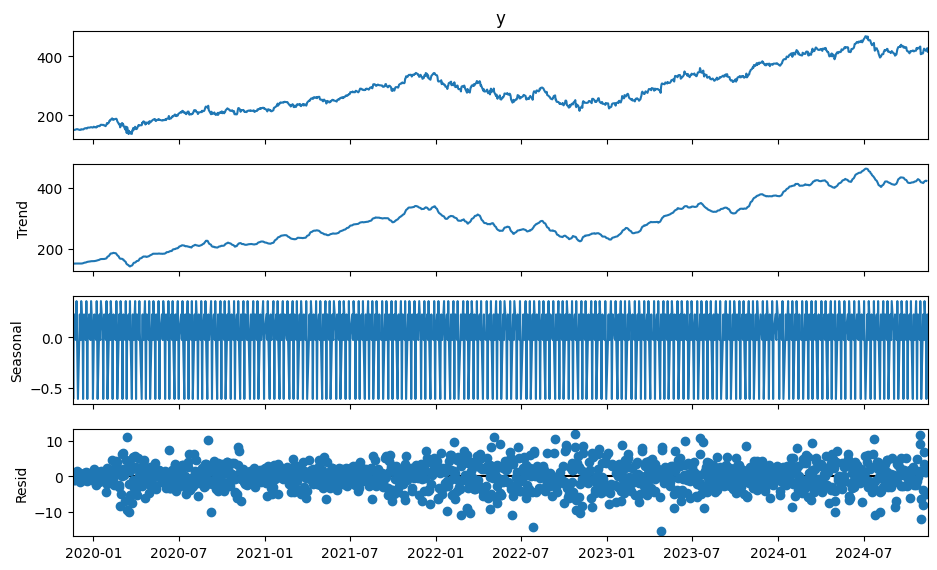

<Axes: xlabel='ds'>

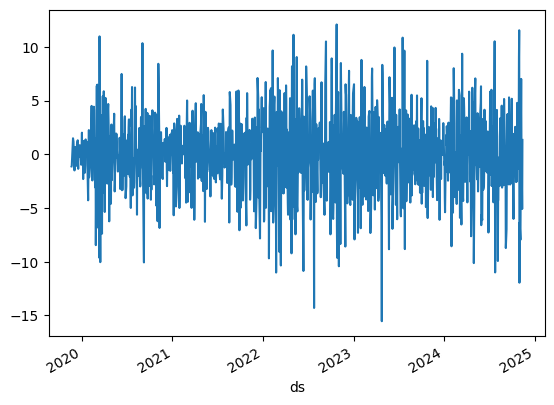

In [ ]:
res = seasonal_decompose(stocks['y'],  period=7)

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

<Axes: xlabel='ds'>

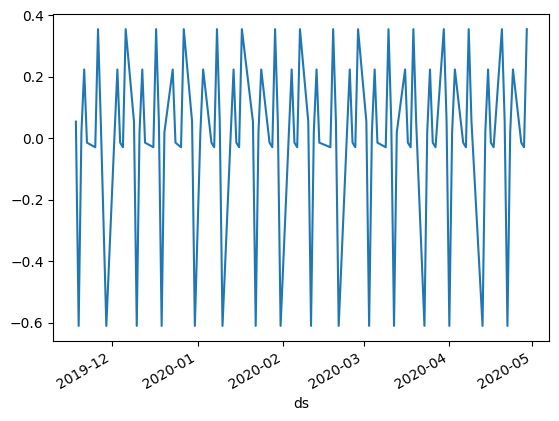

In [ ]:
res.seasonal[:28*4].plot()

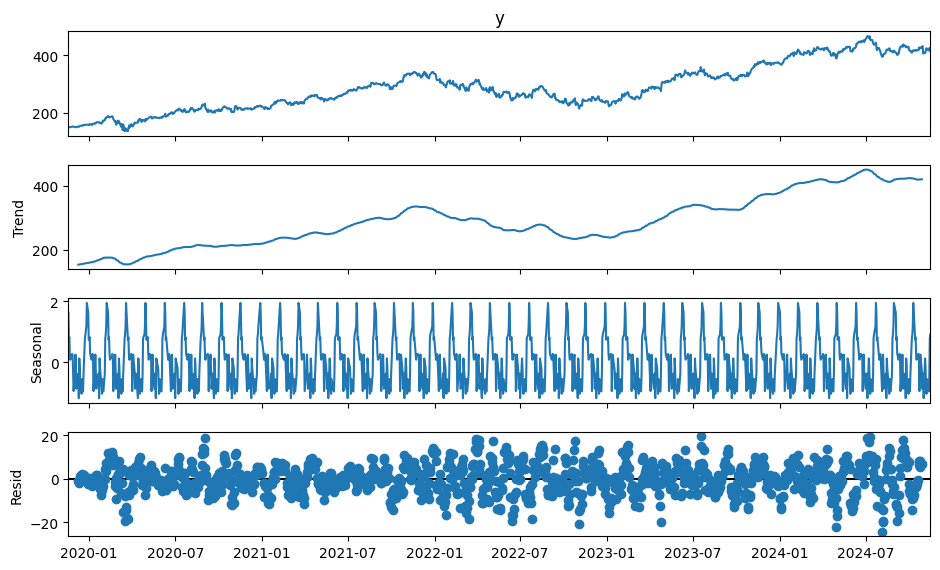

<Axes: xlabel='ds'>

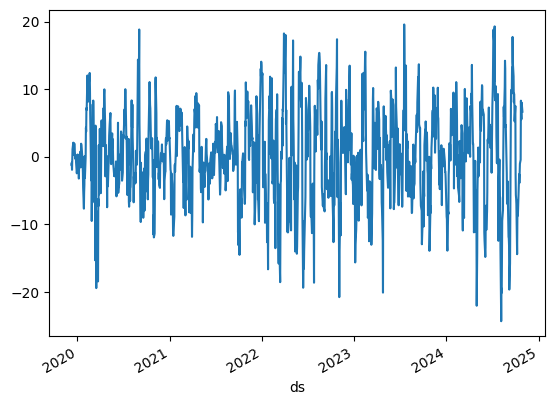

In [ ]:
stl = seasonal_decompose(stocks['y'],  period=28)

fig = stl.plot()
fig.set_size_inches(10, 6)
plt.show()

stl.resid.plot()

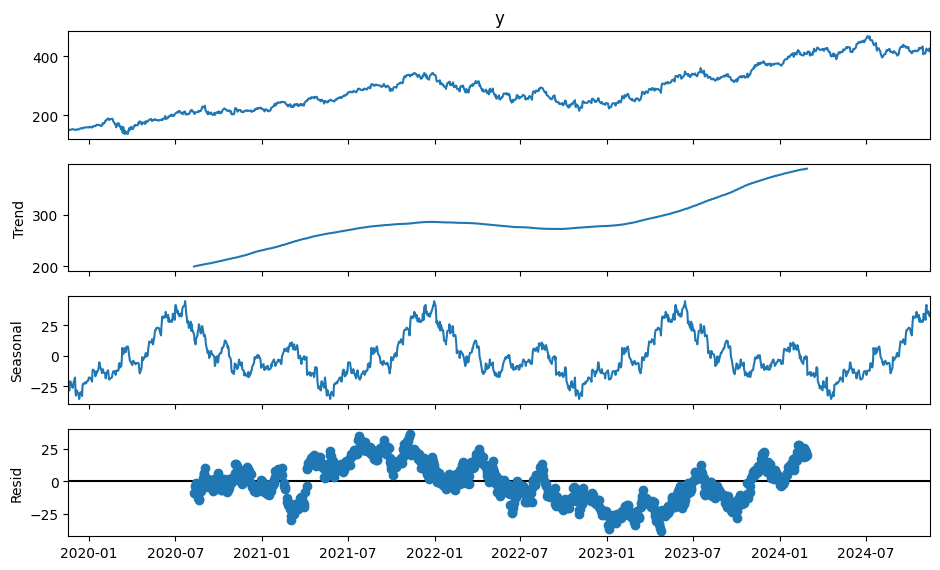

<Axes: xlabel='ds'>

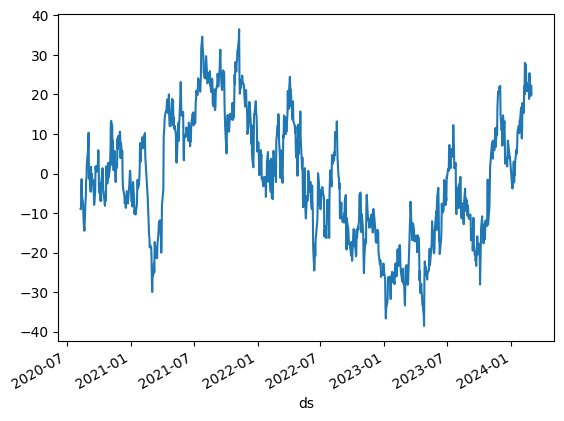

In [ ]:
stl = seasonal_decompose(stocks['y'],  period=365)

fig = stl.plot()
fig.set_size_inches(10, 6)
plt.show()

stl.resid.plot()

#### Residuals after decomposition

Each time residuals were plotted separately. But why?

Ideally, after removing the trend and seasonality, the residuals should behave like white noise.

🌵 **What is white noise?**

White noise has a constant mean, constant variance and is uncorrelated over time (no patterns or dependencies). If the residuals are white noise, this means the decomposition has effectively captured all meaningful structure (trend and seasonality). On the other hand, any remaining patterns in the residuals would suggest the decomposition missed something, like an unaccounted-for trend or seasonality.

Forecasting methods often assume residuals are white noise. If they're not, the model might underperform since residual patterns could bias predictions.

So, **what should we expect from residuals?**

- **NO autocorrelation**
  
  This indicates that all systematic patterns (trend, seasonality, or other dependencies) have been effectively captured by the decomposition

- **stationary**

  Strictly speaking, checking residuals *(after decomposition)* for stationarity is not a requirement when performing time series decomposition.
  
  Stationary residuals suggest that trends and seasonal components have been adequately removed.
  
  If the residuals are non-stationary, this might indicate: 1) A trend was not fully removed. 2) The seasonal period was mis-specified. 3) Some cyclical or long-term components remain in the data.

  At the same time, residuals from a regression model involving time series must be stationary to avoid spurious (=fake) relationships (we'll discuss it later).


**SUM UP:**
- You need stationarity to confirm that residuals have no evolving patterns (e.g., trends).
- You also need residuals to be uncorrelated (no autocorrelation) to ensure all dependencies have been removed.

Let's further check our residuals after decomposition for no autocorrelation (obligatory!!!) + for stationarity (necessary for understanding further steps).

🌵 **How can we check for no autocorrelation?**

With ACF, PACF:

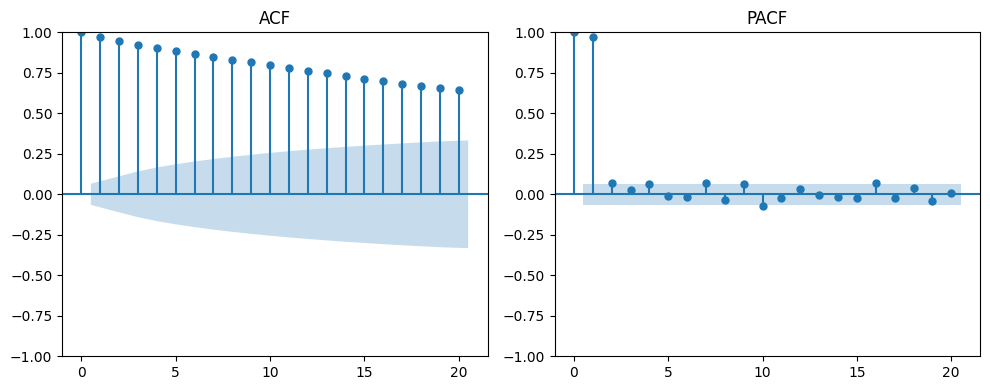

In [ ]:
# 2 graphs side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(stl.resid.dropna(), ax=ax[0], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[0].set_title('ACF')

# PACF
plot_pacf(stl.resid.dropna(), ax=ax[1], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

With Ljung-Box test:


In [ ]:
acorr_ljungbox(stl.resid.dropna(), return_df=True) # nans are only present in the first the last observations

,lb_stat,lb_pvalue
1,844.296998,1.263037e-185
2,1646.720790,0.000000e+00
3,2411.701030,0.000000e+00
4,3146.707352,0.000000e+00
5,3850.954702,0.000000e+00
6,4524.182284,0.000000e+00
7,5173.824275,0.000000e+00
8,5796.824436,0.000000e+00
9,6399.930985,0.000000e+00
10,6976.304466,0.000000e+00


🌵 **What will you say about autocorrelation?**

According to both ACF, PACF and Ljung-Box test our residuals are autocorrelated. This is a bad sign for us, as we might have not included some trend or seasonality dependencies while decomposing.

🌵 **How can we check for stationarity?**

With ADF test:

In [ ]:
adf_test(res.resid.dropna()) # nans are only present in the first 3 and the last 3 observations

Results of Dickey-Fuller Test:
Test Statistic                -1.393308e+01
p-value                        5.047989e-26
#Lags Used                     1.800000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


Residuals are fortunately stationary.

Let's sum up on our residuals.

If the residuals from a time series decomposition are **stationary but autocorrelated**, this suggests that the decomposition has successfully removed long-term trends and seasonality (ensuring stationarity) but has left some short-term dependencies or systematic patterns in the residuals.

The trend and seasonal components may not have fully captured all the patterns, leaving behind residual correlations. Some remaining dynamics in the series are not periodic (seasonal) or monotonic (trend-like) but are systematic (e.g., short-term cyclical patterns).

### STL decomposition

**STL** (Seasonal and Trend decomposition using LOESS) is a more flexible and modern approach compared to classical decomposition. Unlike classical methods, which rely on fixed seasonal components, STL allows for more flexibility by using locally weighted regression (LOESS) to estimate the trend and seasonality. This makes STL more suitable for data with complex seasonality and trends.

*STL* decomposition is an advanced and robust method which is frequently used for business needs. *STL* and its extension, *MSTL*, represent powerful alternatives to classical decomposition for real-world time series.

*Algorithm*

STL is implemented with two loops.
* The *outer loop* initializes weights of observations depending on the size of remainder.
* This considers neighboring observations and gives more weight to closer data points allowing it to adapt to non-linear trends.
* The *inner loop* divides the detrended time series into sub-series and smooths them with LOESS.
* These sub-series are then passed through the low pass filter and seasonality and trend are updated.
* Further iterations allow refining of the estimates.
* Most important parameters are: 1) length of seasonality period; 2) smoothing power of seasonal sub-series (also called seasonal window).

*Limitations*
* Although it is also robust to anomalies, it is not robust to holidays and other special dates.
* Can be only used for additive decomposition. The good part is that it can be easily fixed by an intermediate step of logarithmic data transformation.

*Suitable for*

* Complex and changing seasonal patterns.
* Noisy or outlier-containing data.
* When you need more control over the trend or seasonal smoothing.


Also see [Hyndman](https://otexts.com/fpp3/stl.html) and [Demeshev](https://www.youtube.com/watch?v=bTmsWGNCLfI).

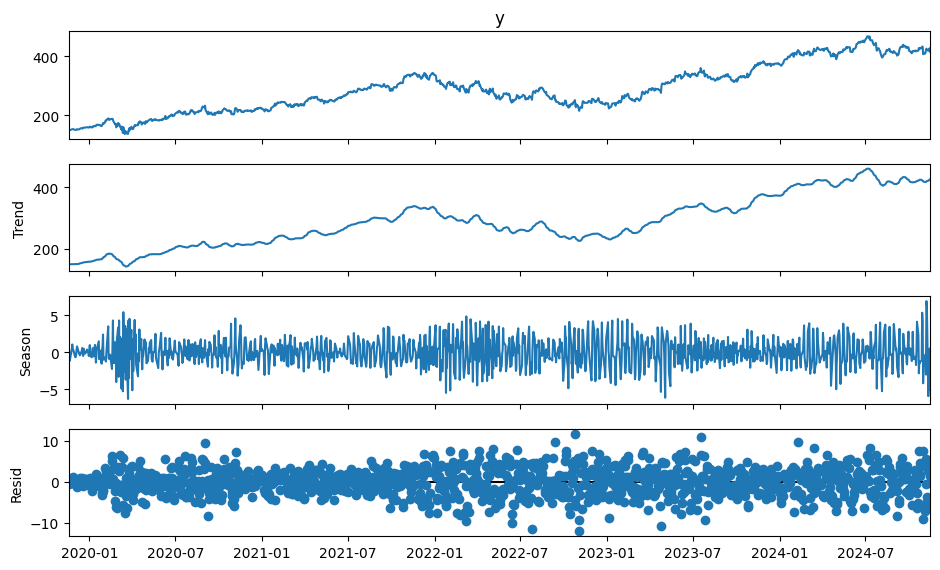

<Axes: xlabel='ds'>

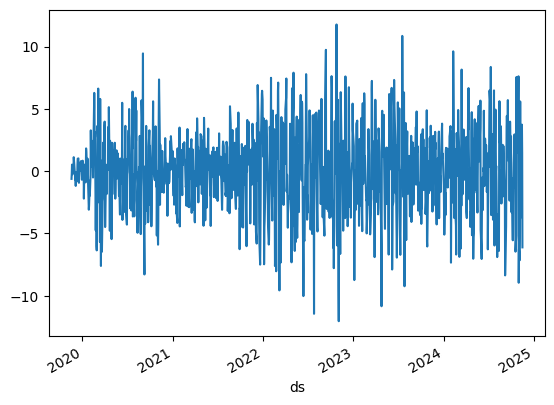

In [ ]:
stl = STL(stocks['y'],  period=7)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

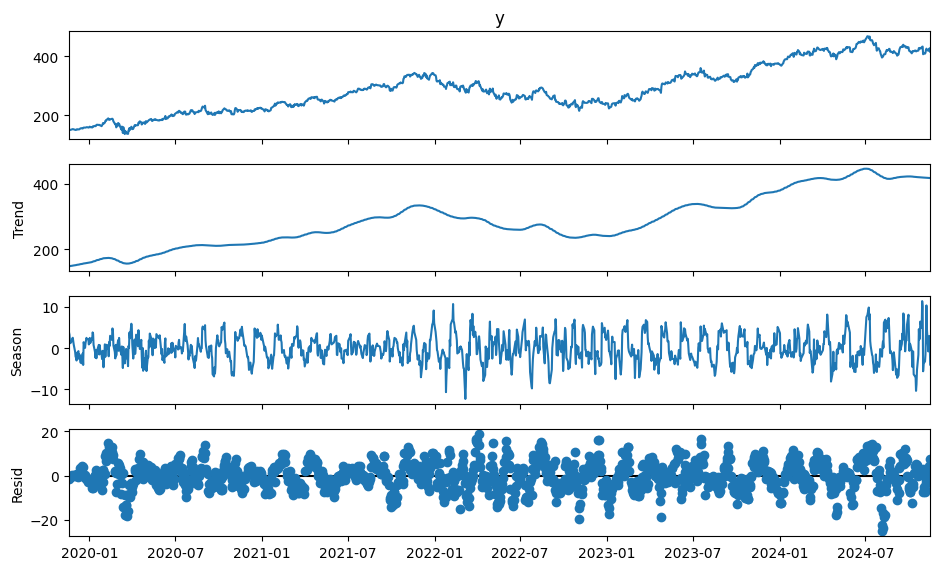

<Axes: xlabel='ds'>

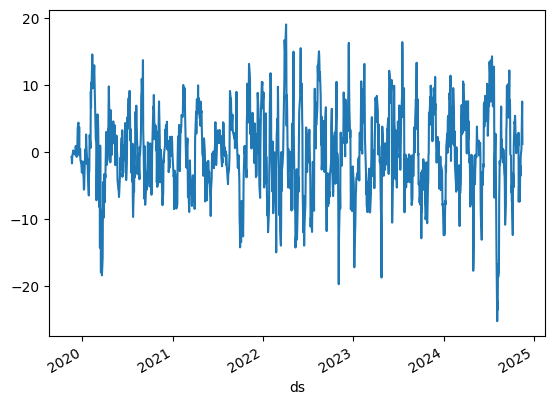

In [ ]:
stl = STL(stocks['y'],  period=28)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

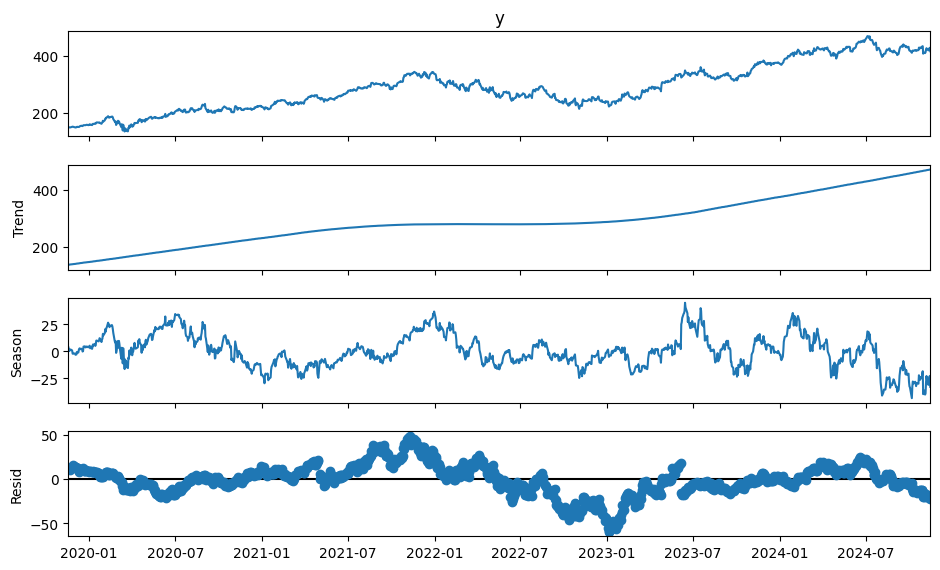

<Axes: xlabel='ds'>

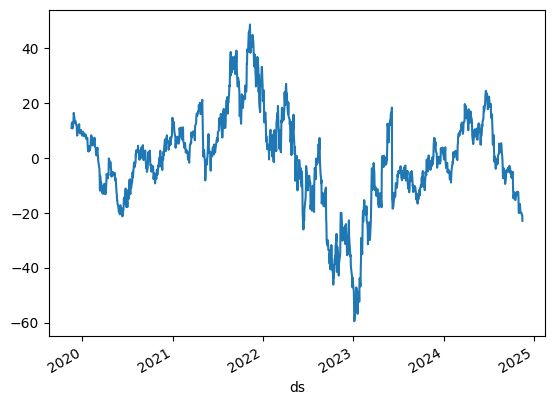

In [ ]:
stl = STL(stocks['y'],  period=365)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

🌵 **What about no autocorrelation and stationarity in this case?**

In [ ]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,1218.610263,5.505486e-267
2,2401.978424,0.000000e+00
3,3552.265427,0.000000e+00
4,4675.230527,0.000000e+00
5,5771.297239,0.000000e+00
6,6835.807048,0.000000e+00
7,7873.032203,0.000000e+00
8,8881.339732,0.000000e+00
9,9866.056353,0.000000e+00
10,10823.199151,0.000000e+00


In [ ]:
adf_test(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                   -2.719377
p-value                           0.070745
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


Situation is worse. Residuals are not stationary and autocorrelated.

🌵 **What may be the problem?**

### MSTL decomposition

A modification of STL, called **MSTL** (Multi-Scale Seasonal and Trend Decomposition using LOESS), was introduced to cope with real-world time series, which usually include several seasonalities. MSTL extends the technique to handle multi-dimensional time series data like these with multiple seasonalities per year. MSTL fits a LOESS surface rather than a single line at each time period to simultaneously extract trends and seasonal patterns.

*Suitable for*

* Same as STL, but use it if you have multiple sasonal patterns.

🌵 **What seasonal period lengths should we take?**

Let's look into the data one more time.

🌵 **What are you noticing?**

In [ ]:
stocks['y'].loc['2024-11-01':]

,y
ds,
2024-11-01,410.37
2024-11-04,408.46
2024-11-05,411.46
2024-11-06,420.18
2024-11-07,425.43
2024-11-08,422.54
2024-11-11,418.01
2024-11-12,423.03
2024-11-13,425.20


Note, that our time series have no weekends.

* 5 - weekly
* 20 - monthly
* 252 - yearly

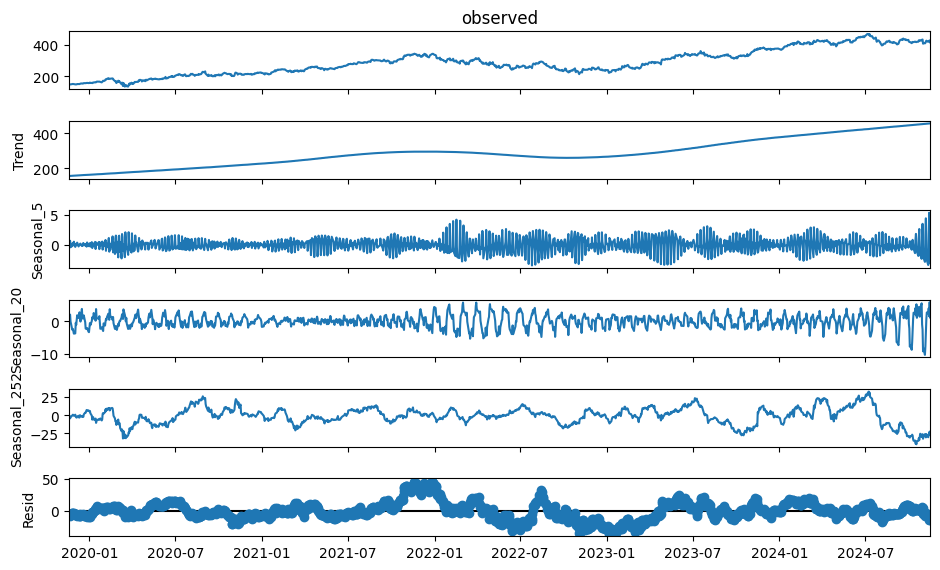

<Axes: xlabel='ds'>

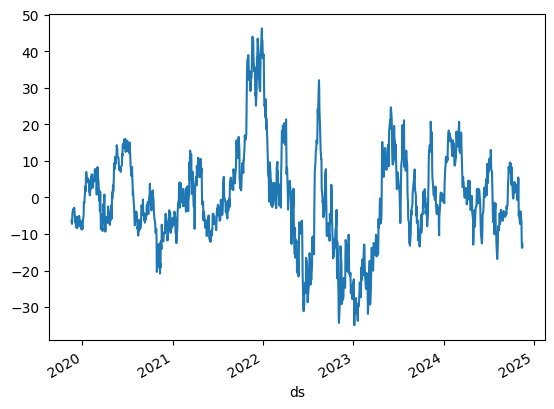

In [ ]:
mstl = MSTL(stocks['y'],  periods=(5, 20, 252))
res = mstl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

🌵 **What about no autocorrelation and stationarity in this case?**

In [ ]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,1187.398850,3.341124e-260
2,2307.468561,0.000000e+00
3,3365.913715,0.000000e+00
4,4363.364099,0.000000e+00
5,5300.707879,0.000000e+00
6,6198.399463,0.000000e+00
7,7061.118112,0.000000e+00
8,7878.122600,0.000000e+00
9,8654.170766,0.000000e+00
10,9372.313090,0.000000e+00


In [ ]:
adf_test(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                   -3.628278
p-value                           0.005243
#Lags Used                       22.000000
Number of Observations Used    1235.000000
Critical Value (1%)              -3.435656
Critical Value (5%)              -2.863883
Critical Value (10%)             -2.568018
dtype: float64


Still, our residuals are stationary and, unfortunately, autocorrelated :(

So, **what should we do in the case when residuals are autocorrelated?**

Here are some recommendations:

* Try adjusting seasonal periods for MSTL decomposition.
* Consider using alternative decomposition techniques (STL, classical) or hierarchical approaches.
* Check stationarity. Model residuals with ARMA (if stationary) or even ARIMA (if not stationary - we'll discuss this model further).
* Explore the impact of external factors on stock price behavior, which could help reduce autocorrelation in residuals.

## Sum up on reduction to stationarity


**When should you use each tecnique?**

* **Differencing** is effective for eliminating long-term trends in non-seasonal data.
* **Percent change** is effective for handling financial time series with high volatility.
* **Classical decomposition** is effective for datasets with, ideally, no anomalies with single seasonal pattern which are constant over time and linear trend.
* **STL decomposition** is ideal for datasets with anomalies with single seasonal pattern which might be changing over time and non-linear trend.
* **MSTL decomposition** is ideal for datasets with multiple seasonal patterns which might be changing over time + everything which STL is suitable for.

# Forecasting with ARMA

**Formula for ARMA(p,q)**

$y_{t} = \alpha_{0} + \alpha_{1}y_{t-1} + ... + \alpha_{p}y_{t-p} + \beta_{1}\epsilon_{t-1} + ... + \beta_{q}\epsilon_{t-q} + \epsilon_{t}$, where $\epsilon_{t}$ - white noise.

🌵 **What ARMA models expect from time series?**

ARMA models require time series to be stationary.

Let's make our stocks time series stationary with differencing. Remember, that we've already performed this and have 1st order differencing in column 'diff'.

In [ ]:
stocks.head()

,y,diff,y_restored_diff,pct_change,y_restored_pct_change
ds,,,,,
2019-11-18,150.34,NaN,NaN,NaN,NaN
2019-11-19,150.39,0.05,150.39,0.033258,150.39
2019-11-20,149.62,-0.77,149.62,-0.512002,149.62
2019-11-21,149.48,-0.14,149.48,-0.093570,149.48
2019-11-22,149.59,0.11,149.59,0.073588,149.59


Let's save the differenced time series and remove nans.

In [ ]:
stocks_diff = stocks[['diff']].dropna().copy()
stocks_diff

,diff
ds,
2019-11-19,0.05
2019-11-20,-0.77
2019-11-21,-0.14
2019-11-22,0.11
2019-11-25,1.64
...,...
2024-11-11,-4.53
2024-11-12,5.02
2024-11-13,2.17


## In-sample forecasts

During lessons 3-4 we've performed only in-sample forecasts. However, today let's look into some details.

Let's start by choosing the right order for our ARMA(p,q) model.

🌵 **How can we find right orders for ARMA(p,q) model?**

With ACF, PACF:

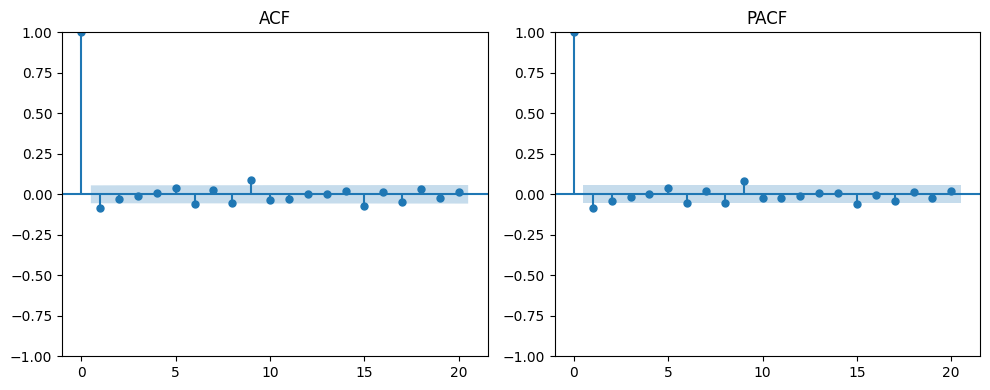

In [ ]:
# 2 graphs side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(stocks_diff, ax=ax[0], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[0].set_title('ACF')

# PACF
plot_pacf(stocks_diff, ax=ax[1], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

With AIC:

In [ ]:
best_params = []
for p in np.arange(0,3): # AR with p up to 3 lag
  for q in np.arange(0,3): # MA with q up to 3 lag
    model = ARIMA(stocks_diff, order=(p,0,q)).fit()
    best_params.append({'p':p, 'q':q, 'AIC':model.aic, 'BIC':model.bic})

pd.DataFrame(best_params).sort_values(by='AIC').head()

,p,q,AIC,BIC
1,0,1,7546.179885,7561.589335
2,0,2,7546.772151,7567.318084
4,1,1,7546.798406,7567.344339
3,1,0,7546.936481,7562.345931
6,2,0,7546.969794,7567.515727


🌵 **What are the most suitable orders (p,q) for ARMA(p,q)?**

Let's take MA(1) model.

In [ ]:
# Instantiate the MA(1) model
model = ARIMA(stocks_diff, order=(0,0,1)) # orders are (p,d,q), p - AR, q - MA

# Fit the model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 1257
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3770.090
Date:                Tue, 03 Dec 2024   AIC                           7546.180
Time:                        15:56:11   BIC                           7561.589
Sample:                             0   HQIC                          7551.971
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2113      0.127      1.667      0.095      -0.037       0.460
ma.L1         -0.0938      0.024     -3.986      0.000      -0.140      -0.048
sigma2        23.5860      0.709     33.253      0.0

Now let's predict $\hat{y_t}$ (called 'y_hat') for our time series $y_t$.

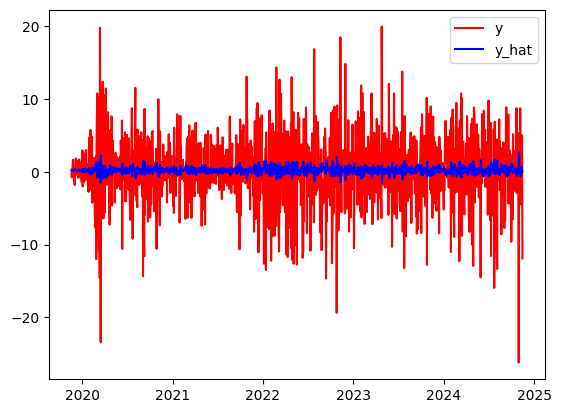

In [ ]:
forecast = model.predict()

plt.plot(stocks_diff,color='red')
plt.plot(forecast,color='blue')
plt.legend(['y','y_hat'])
plt.show()

But how actually does ARMA model estimate the coefficients $\alpha$ and $\beta$?

### Maximum likelihood estimation (MLE)


Simple example (based on [Demeshev](https://www.youtube.com/watch?v=2iRIqkm1mug)):

Imagine that you come to a town, go to the town square and see that there's a fantastic working fountain. You may come up with 2 hypothesis:

1.   The fountain is working every evening.
2.   The fountain is turned on once a year.

What is the probability to see the working fountain in these 2 cases?

1.   1
2.   1/365

**MLE method tells us to choose the hypothesis where the probability will be max.** => We'll presume, that the fountain is working every day.


The **Maximum Likelihood Estimation (MLE)** method is commonly used to estimate the parameters of an ARMA model (AutoRegressive Moving Average model) because it maximizes the likelihood of the observed data under the given model assumptions. The idea is:

1. We have unknown $\alpha$ and $\beta$
2. We want to estimate $\hat{\alpha}$ and $\hat{\beta}$
3. To estimate the unknown $\alpha$ and $\beta$, we'll take $\hat{\alpha}$ and $\hat{\beta}$ which maximize the probability to obtain values $y_t$

It is based on the concept of **likelihood function**.



* The likelihood function $L$ for a set of observations $y_1, y_2, ..., y_n$ with given parameters $\alpha_1, ..., \alpha_n$ and $\beta_1, ..., \beta_n$ is the product of the probability densities of each observed value conditioned on past data:

$L(\alpha, \beta) = \prod(y_1, y_2, ..., y_n|\alpha, \beta)$

* In practice, the likelihood is often maximized by maximizing the log-likelihood function, which simplifies the math (turning the product into a sum).

* To maximize the log-likelihood, numerical optimization methods (such as Newton-Raphson or BFGS) are used. These methods iteratively adjust the model parameters to find the values that maximize the likelihood function.

* The result is the set of parameters $\hat{\alpha}$ and $\hat{\beta}$ that most likely explain the observed data.

When you fit an ARMA model using libraries like statsmodels in Python, it internally uses MLE to estimate the model parameters. This is why fitting an ARMA model involves specifying the order (p, q) and then calling .fit() on the model, where the library computes the likelihood of the data under the chosen ARMA model and adjusts the parameters accordingly.

### AIC, AICc, BIC

Remember, that last time we discussed that AIC, BIC help to identify a model that provides a good fit to the data while penalizing unnecessary complexity.

Actually, these criterions are based on the concept of likelihood.

$AIC = −2ln(L)+2(p+q+k+1)$,

where $L$ is the maximized likelihood function, $k=1$ if $const≠0$ and $k=0$ if $const=0$. Note that the last term in parentheses is the number of parameters in the model (including $σ^2$ - the variance of the residuals - see summary matrix after ARMA fit).

The AICc is a correction to the AIC, particularly useful when the sample size $n$ is small relative to the number of parameters in the model.

$AICc = AIC + \frac{2(p+q+k+1)(p+q+k+2)}{n-p-q-k-2}$

The Bayesian Information Criterion (BIC) is another model selection tool but with a stronger penalty for the number of parameters compared to AIC. This penalty increases with sample size, making BIC particularly useful when trying to avoid overfitting with large datasets.

$BIC = AIC + (ln(n)-2)(p+q+k+1)$

How to calculate AICc?

In [ ]:
# AIC and number of parameters
aic = model.aic
k = len(model.params)  # number of parameters in the model
n = len(stocks_diff)  # sample size

# Calculate AICc
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

aicc

7546.199039029563

These information criteria tend to be good guides to selecting the appropriate p and q.

### Residuals of the model

**Formula**

$e_t = y_t - \hat{y_t}$

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values.


A good forecasting method will yield residuals with the following properties:

* **The residuals are uncorrelated**. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
* **The residuals have zero mean**. If the residuals have a mean other than zero, then the forecasts are biased.

**Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved.** It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

Now, let's check our residuals.

In [ ]:
forecast = pd.DataFrame(forecast)
forecast.columns = ['diff']
forecast

,diff
ds,
2019-11-19,0.211310
2019-11-20,0.226304
2019-11-21,0.304723
2019-11-22,0.253010
2019-11-25,0.224720
...,...
2024-11-11,0.450592
2024-11-12,0.678322
2024-11-13,-0.195793


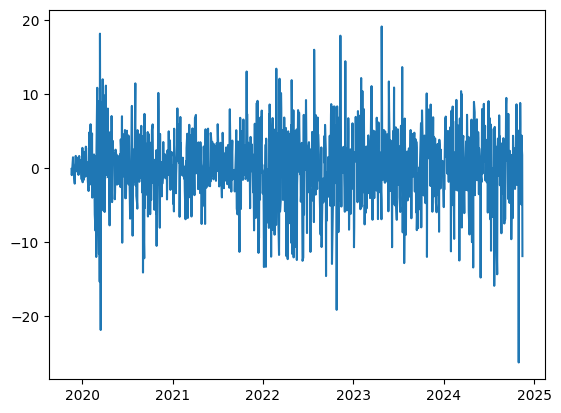

In [ ]:
residuals = stocks_diff - pd.DataFrame(forecast)

plt.plot(residuals)

Let's check the mean:

In [ ]:
residuals.mean()

,0
diff,0.000143


Let's check autocorrelation:

In [ ]:
acorr_ljungbox(residuals, return_df=True)

,lb_stat,lb_pvalue
1,0.012151,0.912226
2,1.357612,0.507222
3,1.605570,0.658128
4,1.731571,0.784975
5,3.106405,0.683585
6,7.250097,0.298337
7,7.564933,0.372514
8,10.280091,0.245915
9,18.906699,0.025998
10,19.863648,0.030569


🌵 **Are our residuals good? What would you say about the model then?**

The mean is 0, there's no autocorrelation.

## Out-of-sample forecasts

Finally, we can move to out-of-sample forecasts.

Out-of-sample forecasting with ARMA models refers to making predictions on a portion of the dataset that was not used during the model training process. This is a key step in evaluating the generalizability of the model to unseen data. The idea is to assess how well the ARMA model can forecast future data, based on past observations, and test its performance on data that was held back (out-of-sample).

In [ ]:
train_size = int(len(stocks_diff) * 0.98)
train, test = stocks_diff[:train_size], stocks_diff[train_size:]

In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=train.index, y=train['diff'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['diff'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's now fit a new model to our train and forecast with MA(1) model.

In [ ]:
# Instantiate the MA(1) model
model = ARIMA(train, order=(0,0,1)) # orders are (p,d,q), p - AR, q - MA

# Fit the model
model = model.fit()

In [ ]:
forecast_size = len(stocks_diff) - train_size

forecast_size

26

In [ ]:
y_hat = model.forecast(steps=forecast_size)
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

,predicted_mean
ds,
2024-10-11,0.359261
2024-10-14,0.215796
2024-10-15,0.215796
2024-10-16,0.215796
2024-10-17,0.215796
2024-10-18,0.215796
2024-10-21,0.215796
2024-10-22,0.215796
2024-10-23,0.215796


In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=train.index, y=train['diff'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['diff'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=y_hat.index, y=y_hat['predicted_mean'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

For out-of-sample forecasting with MA models, the forecasted values are based on the mean and the last known error. However, once you reach a point in time where there are no more actual errors (the end of your time series), the model will rely on the mean of the series.

So, for long-term forecasts beyond the available data, the model's forecasts will tend toward the mean of the series, as there are no new errors or shocks to influence the prediction. This is a limitation of the MA models, especially when forecasting many steps ahead.

Finally, let's reverse our time series and the forecast to the original scales.

In [ ]:
y_hat.columns = ['diff']
stocks_forecasted = pd.concat([train, y_hat])
stocks_forecasted.head()

,diff
ds,
2019-11-19,0.05
2019-11-20,-0.77
2019-11-21,-0.14
2019-11-22,0.11
2019-11-25,1.64


In [ ]:
y_0 = stocks['y'].iloc[0] # take the first value as the start
stocks_forecasted['y_restored'] = np.cumsum(stocks_forecasted['diff'])+y_0
stocks_forecasted.head()

,diff,y_restored
ds,,
2019-11-19,0.05,150.39
2019-11-20,-0.77,149.62
2019-11-21,-0.14,149.48
2019-11-22,0.11,149.59
2019-11-25,1.64,151.23


In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=stocks.index, y=stocks['y'], mode='lines', name='y', line=dict(color='blue'))
fig.add_scatter(x=stocks_forecasted.index[train_size:], y=stocks_forecasted['y_restored'][train_size:], mode='lines', name='y_hat', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Task for 20 minutes

🌵

**1. Perform percent change transformation of the time series.**

**2. Choose suitable (p,q) orders for ARMA.**

**3. Perform in-sample and out-of-sample forecasts with ARMA (don't forget to split your time series).**

**4. Revert to original time series.**

# AutoRegressive Integrated Moving Average - ARIMA(p,d,q)

ARMA models work only with stationary time series. As a result, we have to always perform some operations (e.g. differencing) to obtain stationary time series and then be able to forecast it with ARMA.

However, there's ARIMA model. **ARIMA (AutoRegressive Integrated Moving Average)** is a widely used time series forecasting model that combines three key components: autoregression (AR), differencing (I for integration), and moving average (MA). It is specifically designed to handle **non-stationary time series** data and forecast future values based on both past values and past forecast errors.

**Formula**

$y_{t} = \alpha_{0} + \alpha_{1}y'_{t-1} + ... + \alpha_{p}y'_{t-p} + \beta_{1}\epsilon_{t-1} + ... + \beta_{q}\epsilon_{t-q} + \epsilon_{t}$, where $\epsilon_{t}$ - white noise, $y'_t$ - differenced series.


Let's remeber our initial time series. We know, that differencing of the 1st order make our time series stationary. Let's build ARIMA(0,1,1) model for the time series.

In [ ]:
stocks = stocks['y']

In [ ]:
# Instantiate the MA(1) model
model = ARIMA(stocks, order=(0,1,1)) # orders are (p,d,q), p - AR, q - MA, d - I

# Fit the model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3771.534
Date:                Tue, 03 Dec 2024   AIC                           7547.068
Time:                        15:56:12   BIC                           7557.341
Sample:                             0   HQIC                          7550.929
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0910      0.024     -3.865      0.000      -0.137      -0.045
sigma2        23.6404      0.706     33.468      0.000      22.256      25.025
Ljung-Box (L1) (Q):                   0.00   Jarque-

## In-sample forecasts

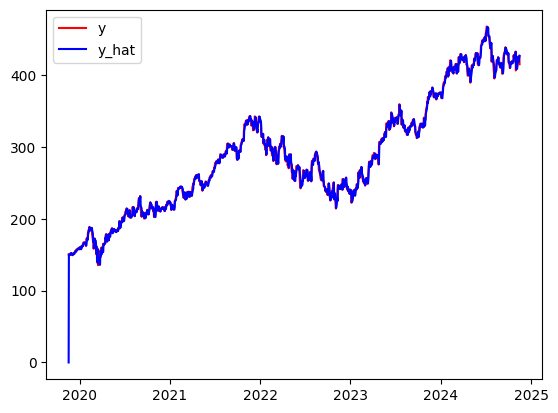

In [ ]:
forecast = model.predict()

plt.plot(stocks,color='red')
plt.plot(forecast,color='blue')
plt.legend(['y','y_hat'])
plt.show()

Let's zoom in:

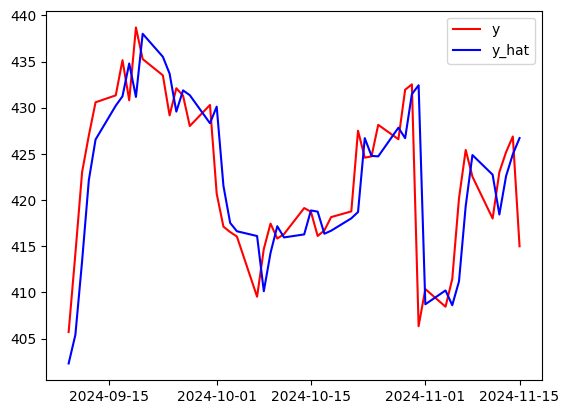

In [ ]:
plt.plot(stocks[-50:],color='red') # lasr 50 observations
plt.plot(forecast[-50:],color='blue')
plt.legend(['y','y_hat'])
plt.show()

## Out-of-sample forecasts

In [ ]:
train_size = int(len(stocks) * 0.98)
train, test = stocks[:train_size], stocks[train_size:]

In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's now fit a new model to our train and forecast with ARIMA(0,1,1) model.

In [ ]:
# Instantiate the ARIMA(0,1,1) model
model = ARIMA(train, order=(0,1,1)) # orders are (p,d,q), p - AR, q - MA, d - I

# Fit the model
model = model.fit()

In [ ]:
forecast_size = len(stocks_diff) - train_size + 1

forecast_size

26

In [ ]:
y_hat = model.get_forecast(steps=forecast_size)
y_hat = y_hat.predicted_mean
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

,predicted_mean
ds,
2024-10-11,415.958862
2024-10-14,415.958862
2024-10-15,415.958862
2024-10-16,415.958862
2024-10-17,415.958862
2024-10-18,415.958862
2024-10-21,415.958862
2024-10-22,415.958862
2024-10-23,415.958862


In [ ]:
fig = px.line(title="Microsoft closing prices (daily) - diff(1)")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=y_hat.index, y=y_hat['predicted_mean'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Note that here for the prediction we got so called **predicted_mean**. predicted_mean is the expected future value: this is the most reliable "normal forecast" ARIMA provides. ARIMA assumes future values are probabilistic, following a statistical distribution. The predicted_mean is the expected value (i.e., the most likely single point estimate). This mean is often sufficient for many business and operational use cases. However, you may generate more interesting results while using confidence intervals which the model also provides.

It is important to note that AIC, AICc, BIC information criteria tend not to be good guides to selecting the appropriate order of differencing (d) of a model. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable. So we need to use some other approach to choose d, and then we can use the AIC or BIC to select p and q.

How to choose d?

**Iterative differencing:**

1.   Start with $d = 0$ (no differencing). If the series is already stationary, you can use $d = 0$ and proceed with fitting the AR and MA components.
2.   If the series is non-stationary, apply first-order differencing ($d = 1$): subtract each observation from the previous one. After differencing, perform the ADF test again.
3.   If the series is still non-stationary after first differencing, apply second-order differencing ($d = 2$) and test again.
4.   Repeat the process until you achieve stationarity. Usually, $d = 0$, $d = 1$, or $d = 2$ are sufficient.


## Auto-ARIMA

**Auto ARIMA (Auto-Regressive Integrated Moving Average)** is an automated algorithm used for selecting the best-fitting ARIMA model for time series forecasting. It streamlines the process of finding the optimal model parameters p, d, q, which are essential for ARIMA models.

In [ ]:
# Fit Auto ARIMA model
model = auto_arima(train, stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())

# Make a forecast for the next periods
forecast_auto_arima = model.predict(n_periods=forecast_size)
print(forecast_auto_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7369.180, Time=2.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7374.872, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7367.814, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7367.191, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7375.324, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7368.262, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7368.200, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7369.823, Time=1.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7368.179, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.364 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1232
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3680.596
Date:                Tue, 03 Dec 2024   AIC      

**How does Auto-ARIMA work?**

The **auto_arima** function in pmdarima by default implements an automated process for selecting the optimal ARIMA model parameters using a stepwise algorithm based on the Hyndman-Khandakar method. This method combines unit root tests, minimisation of the AICc and MLE to obtain an ARIMA model.

See [Hyndman](https://otexts.com/fpp3/arima-r.html) for more details.

In [ ]:
forecast_auto_arima = pd.DataFrame(forecast_auto_arima)
forecast_auto_arima['ds'] = test.index
forecast_auto_arima.set_index('ds', inplace=True)
forecast_auto_arima.columns = ['y_hat']

forecast_auto_arima

,y_hat
ds,
2024-10-11,416.199275
2024-10-14,416.415082
2024-10-15,416.630889
2024-10-16,416.846696
2024-10-17,417.062503
2024-10-18,417.278310
2024-10-21,417.494118
2024-10-22,417.709925
2024-10-23,417.925732


In [ ]:
fig = px.line(title="Microsoft closing prices (daily)")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_auto_arima.index, y=forecast_auto_arima['y_hat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

ARIMA in both manual and Auto ARIMA should, in theory, give you similar forecasts, but the Auto ARIMA function usually does a better job of selecting the best parameters, optimizing residuals, and refining the model. This can lead to better forecast performance, even for the same parameters.

Moreover, in pmdarima, Auto ARIMA automatically considers drift and constant terms when fitting models. Even for differenced series (d > 0), Auto ARIMA can add a small upward or downward trend if it improves the fit. This is why the forecast may include gradual changes rather than remaining constant.



Task for 10 minutes

🌵 **Predict trend of stocks with Auto-ARIMA.**

**1. Perform MSTL decomposition of the time series and extract trend - further you will only need trend.**

**2. Perform out-of-sample forecasts with Auto-ARIMA (don't forget to split your time series).**

<Axes: xlabel='ds'>

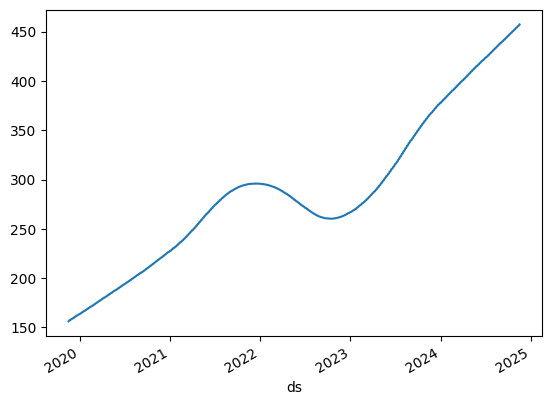

In [ ]:
trend = res.trend
trend.plot()

# Regressions

## Simple and multiple linear regressions

In the simplest case, **the simple regression model** allows for a linear relationship between the forecast variable y and a single predictor variable x:

$y_t = \beta_0 + \beta_1*x_t + \epsilon_t$

Here, $y$ is the dependent variable and $x$ is the independent variable.

**Multiple linear regressions** is very similar to simple linear regression, but it incorporates multiple predictors, which could include lagged values of the time series or external covariates:

$y_t = \beta_0 + \beta_1*x_{1,t} + \beta_2*x_{2,t} + ... + + \beta_k*x_{k,t} + \epsilon_t$

The coefficients $\beta_1, ..., \beta_k$ measure the effect of each predictor after taking into account the effects of all the other predictors in the model. Thus, the coefficients measure the **marginal effects** of the predictor variables. Marginal effect refers to the impact of a change in one predictor variable on the dependent variable, holding all other predictors constant.

### Assumptions

When we use a linear regression model, we are implicitly making some assumptions about the variables.

1.  The model is a reasonable approximation to reality; that is, the relationship between the forecast variable and the predictor variables satisfies some linear equation.

2. The errors $\epsilon_t$ must:

*  have mean zero; otherwise the forecasts will be systematically biased.
*  be not autocorrelated; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
* they are unrelated to the predictor variables; otherwise there would be more information that should be included in the systematic part of the model.

3.  Each predictor $x_t$ is not a random variable. If we were performing a controlled experiment in a laboratory, we could control the values of each x (so they would not be random) and observe the resulting values of y. With observational data (including most data in business and economics), it is not possible to control the value of x, we simply observe it. Hence we make this an assumption.

4.  Model residuals must be stationary in order to avoid spurious (=fake) regressions, if there are no properties of stationarity among the residuals, then basically our results tend to produce
fake relationships in our model.


## Predictors

### Dummy regressors

**Dummy regressors** for time series are used in time series analysis to model the effects of special events that influence the series, such as specific time periods, holidays, special events, or changes in policy. Dummy regressors mark periods of special event with 1 and everyting other - with 0.

The main advantage of dummy variables is that they can be easily modeled into the future (e.g. for your New Year dummy regressor, you can mark all the following New Years for your out-of-sample forecasts).

**US-China Trade War (2018 - 2020)**

* Start Date: July 6, 2018, when the US imposed tariffs on $34 billion worth of Chinese goods.

* End Date: January 15, 2020, when the Phase One trade deal was signed between the US and China.

**COVID-19 Pandemic (2020 - Present)**
* Start Date: January 2020, when the World Health Organization declared a public health emergency.
* Ongoing Impact: Though the pandemic officially began in 2020, its economic repercussions have continued well beyond 2020, with many countries still dealing with its effects as of 2024.

In [ ]:
date_range = pd.date_range(start=stocks.index.min(), end=stocks.index.max())

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

regressors

,ds
0,2019-11-18
1,2019-11-19
2,2019-11-20
3,2019-11-21
4,2019-11-22
...,...
1820,2024-11-11
1821,2024-11-12
1822,2024-11-13
1823,2024-11-14


In [ ]:
# US-China trade war period
trade_war_start = "2018-07-06"
trade_war_end = "2020-01-15"

# Mark the trade war dates with 1 and other dates with 0
regressors['trade_war'] = ((regressors['ds'] >= trade_war_start) \
                            & (regressors['ds'] <= trade_war_end)).astype(int)

regressors = regressors[~regressors['ds'].dt.weekday.isin([5, 6])] # remove weekends
regressors.set_index('ds', inplace=True)

regressors = regressors.join(stocks).dropna()['trade_war'] # there're several nulls in stocks
regressors = pd.DataFrame(regressors)

regressors

,trade_war
ds,
2019-11-18,1
2019-11-19,1
2019-11-20,1
2019-11-21,1
2019-11-22,1
...,...
2024-11-11,0
2024-11-12,0
2024-11-13,0


Task for 5 minutes

🌵 **Write code for creating COVID-19 regressor**

### Continuous regressors

Let's download the whole dataset with all the info about Microsoft stocks.

In [ ]:
stocks = pd.read_csv('microsoft.csv', parse_dates=['Date'])

In [ ]:
stocks.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-11-15,$415.00,28247640,$419.82,$422.80,$413.64
1,2024-11-14,$426.89,30246880,$425.00,$428.17,$420.00
2,2024-11-13,$425.20,21502190,$421.64,$429.325,$418.21
3,2024-11-12,$423.03,19401200,$418.25,$424.44,$417.20
4,2024-11-11,$418.01,24503320,$422.515,$424.81,$416.00


Let's consider closing price as a continous numeric predictor.

In [ ]:
stocks.rename(columns={'Date':'ds', 'Close/Last':'y', 'Open':'x'}, inplace=True)
stocks['y'] = stocks['y'].apply(lambda x: x[1:]).astype(float)
stocks['x'] = stocks['x'].apply(lambda x: x[1:]).astype(float)

stocks = stocks[['ds','y', 'x']].sort_values(by='ds').set_index('ds')

In [ ]:
fig = px.line(title="Microsoft closing and open prices (daily)")
fig.add_scatter(x=stocks.index, y=stocks['y'], mode='lines', name='closing price', line=dict(color='blue'))
fig.add_scatter(x=stocks.index, y=stocks['x'], mode='lines', name='open price', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()


# SUM UP

* Discussed different algorithms of reduction to stationarity: differencing, percent change, decompositions (classical, STL, MSTL) and importance of not autocorrelated residuals
* Discussed MLE and origin of AIC, BIC
* Discussed out-of-sample forecasting with ARMA, ARIMA and auto-ARIMA models
* Discussed regression models for time series
* Tried dummy regressors (or predictors) and continous regressors (or predictors)

Please, leave your feedback [here](https://forms.gle/5bhdQijqfojV8UF47), let's make our lessons more effective :)